# #6

En este notebook, realizaremos un análisis de clustering sobre datos de consumo eléctrico horario. El análisis se basa en procesar los datos brutos de consumo eléctrico (mediciones horarias) para construir **perfiles completos de consumo diario** que luego serán clusterizados:

## Objetivos del cuaderno:

**1. Optimización de la Metodología de Clustering para Series Temporales:**
- Desarrollar el método `K-ISAC_TLP` dada su eficiencia y aplicabilidad en diversas series temporales de consumo eléctrico.

**2. Análisis Comparativo Extendido de Métricas de Clustering:**
- Realizar un análisis comparativo en profundidad de `K-ISAC_TLP` con otros métodos (codo, silueta, etc.) en diferentes datasets, evaluando fortalezas y debilidades de cada uno.

**3. Aplicar K-Means para agrupar los datos según los patrones de consumo.**
- Implementar el algoritmo `Bisecting K-Means` para identificar patrones de consumo eléctrico en los datos preprocesados, analizando la calidad de los clusters formados.

**4. Analisis de los resultados:**
- Analizar los resultados obtenidos de los diferentes métodos de clustering, identificando patrones y tendencias en los datos.
- Evaluar la calidad de los clusters formados y su aplicabilidad en el contexto del consumo eléctrico.

## Carga y Preparación de Datos

In [71]:
import pandas as pd
from sklearn.cluster import BisectingKMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import math
import warnings
import pickle

warnings.filterwarnings("ignore")

In [72]:
df = pd.read_csv("../flatten_data_watts.csv", sep=",", index_col=[0, 1])

### Normalización:

En este análisis, hemos decidido no aplicar ningún tipo de normalización o escalado a los datos de consumo eléctrico. Las razones principales son las siguientes:

1. **Interpretación práctica**:  
    Al mantener las magnitudes reales de consumo (en Wh), los perfiles resultantes son más interpretables y útiles para aplicaciones prácticas. Por ejemplo, un perfil con picos de 1000 Wh tiene un significado claramente diferente al de otro con picos de 100 Wh.

2. **Preservación de diferencias absolutas**:  
    La normalización o escalado podría ocultar diferencias clave en el consumo absoluto, lo que es crucial para identificar patrones reales de comportamiento. Por ejemplo, dos perfiles con formas similares pero magnitudes muy diferentes podrían ser tratados como iguales tras la normalización, perdiendo información valiosa.

3. **Relevancia en el contexto eléctrico**:  
    En el análisis de consumo eléctrico, las magnitudes absolutas son esenciales para tomar decisiones, como dimensionar infraestructura o identificar usuarios con altos consumos.


In [73]:
with open('pkls/k_values.pkl', 'rb') as f:
    k_values = pickle.load(f)

with open('pkls/mae_values.pkl', 'rb') as f:
    mae_values = pickle.load(f)

with open('pkls/irreleCluster_values.pkl', 'rb') as f:
    irreleCluster_values = pickle.load(f)

## Determinación del Número Óptimo de Clusters

## Fundamentos del K-ISAC_TLP y Métrica MAE
**Objetivo principal**:  
Determinar el número óptimo de clusters ($k$) que minimice el **Error Absoluto Medio (MAE)** entre los datos originales y los centroides asignados.

**Fórmula del MAE**:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |X_i - C_{l_i}|
$$
Donde:
- $X_i$: Punto de datos.
- $C_{l_i}$: Centroide del cluster asignado a $X_i$.

**Lógica del algoritmo**:
1. Para cada $k$ en un rango (ej. 2 a 10):
   - Aplicar K-Means y calcular MAE (datos vs centroides).
2. Seleccionar el $k$ que **minimice el MAE**.

**Ventajas clave**:
✔ **Enfoque temporal**: Optimizado para patrones de consumo eléctrico (series horarias).  
✔ **Interpretabilidad**: MAE es más intuitivo que la inercia (distancias cuadradas).  
✔ **Robustez**: Menos sensible a outliers que el coeficiente de silueta.

### Comparación con Métodos Tradicionales

| Método               | Métrica                          | Uso Típico               | Ventaja de K-ISAC_TLP               |
|----------------------|----------------------------------|--------------------------|-------------------------------------|
| **K-ISAC_TLP**       | MAE (error absoluto)             | Series temporales        | Optimizado para patrones temporales |
| **Método del Codo**  | Inercia (suma de cuadrados)      | Datos genéricos          | MAE es más interpretable            |
| **Coeficiente Silueta** | Silhouette Score ([-1, 1])    | Clusters no convexos     | MAE más estable en series           |

### ¿Por qué MAE para clustering temporal?
- **Contexto eléctrico**:  
  Los centroides representan patrones típicos de consumo (ej: "madrugada baja demanda").  
  El MAE cuantifica directamente **cuánto se desvía** cada día de su patrón asignado.  
- **Estabilidad**:  
  Menos afectado por outliers que la inercia (que usa cuadrados de distancias).  

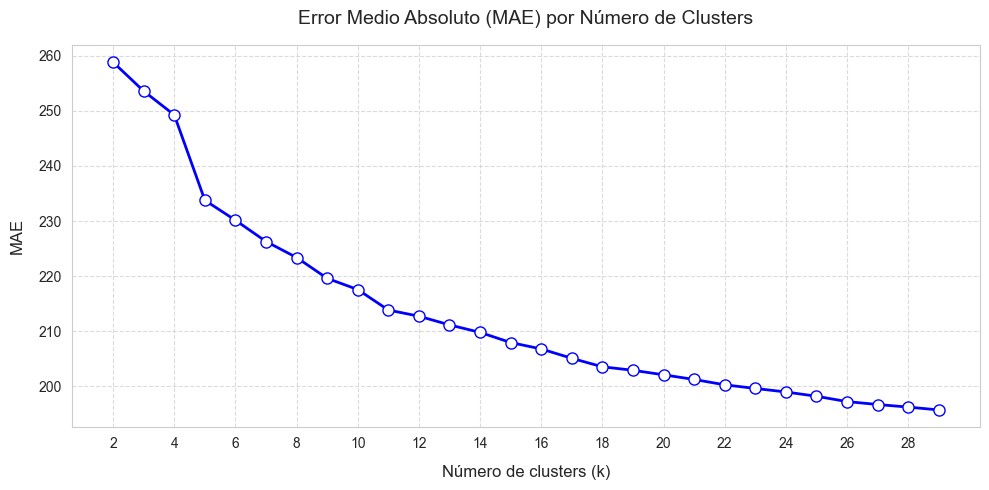

In [74]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, mae_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Error Medio Absoluto (MAE) por Número de Clusters', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('MAE', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

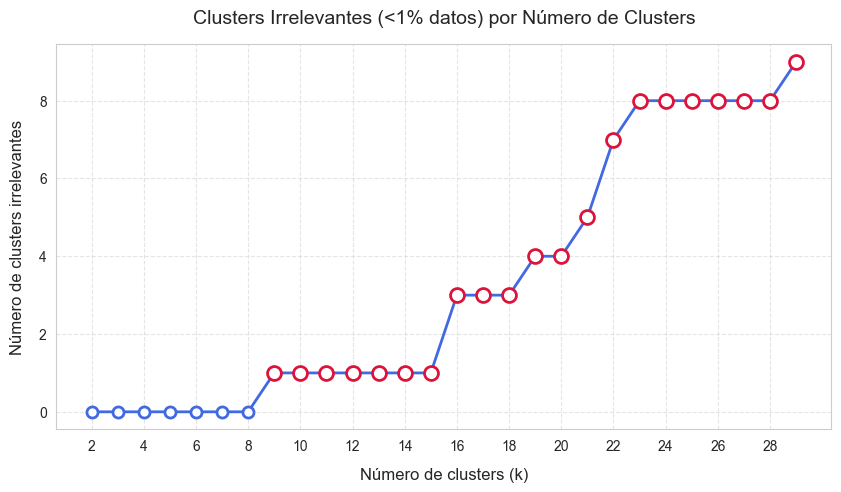

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, irreleCluster_values, 'o-', 
         color='royalblue', 
         markersize=8,
         markerfacecolor='white',
         markeredgewidth=2,
         linewidth=2)
for k, count in zip(k_values, irreleCluster_values):
    if count > 0:
        plt.plot(k, count, 'o', 
                 color='crimson', 
                 markersize=10,
                 markerfacecolor='white',
                 markeredgewidth=2)
plt.title('Clusters Irrelevantes (<1% datos) por Número de Clusters', 
          pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Número de clusters irrelevantes', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.5)

## Algorithm 2: k-ISAC_TLP procedure
**Input:**
```python
// DATA: values for 𝑘 to be considered in the range
// defined by the experts
𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥] = 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
// DATA: List with MAE values measured for different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
// DATA: List with the number of irrelevant clusters modeled for
// different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
```
**Output:**
```python
// values for 𝑘 that meet the criteria defined by experts
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[]
```
**Procedure:**
```python
// Configure parameters before calling ISAC method
𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠 ← 3;
𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ← 3;
// Area threshold for MAE curve
𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝐴𝑟ｅ𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠);
// Slope threshold for MAE curve
𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝑆𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                            𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠);
// Area threshold for curve with number of irrelevant clusters
𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 1.5;
// Slope threshold for curve with number of irrelevant clusters (degrees)
𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 22.5;
// Variables to store best 𝑘 values for every curve
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                     𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                     𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                     𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠,
                      𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                      𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                      𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[] ← 𝑐𝑜𝑚𝑚𝑜𝑛𝑉𝑎𝑙𝑢𝑒𝑠𝑂𝑛(𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸,
                         𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[]);
```

> **Nota:** En el documento, se explica que los umbrales de área y pendiente no son adaptativos en los "irreleant clusters" por diseño.  Los umbrales se establecen de forma fija para evitar detecciones tempranas e inconsistentes, y para reducir los requisitos de estabilidad excesivamente estrictos que requerirían escenarios perfectos. 

In [76]:
# Utils
def random_color():
    x = [0, 1, 2]
    y = [0, 1, 2]
    r = random.random()
    b = random.random()
    g = random.random()
    color_ = (r, g, b)
    return color_

def calculateArea(p1,p2,p3):
    areaTriangle = abs (1/2 * ( ( (p2[0]*p1[1])-(p1[0]*p2[1]) )+ ( (p3[0]*p2[1])-(p2[0]*p3[1]) ) +
    ( (p1[0]*p3[1])-(p3[0]*p1[1]) ) ) )
    return areaTriangle

def calculateSlope(p1,p2):
    slopeTwoPoints = math.degrees(math.atan((p2[1]-p1[1])/(p2[0]-p1[0])))
    return slopeTwoPoints

def RenderTriangle(p1, p2, p3, ax, facecolor, edgecolor="none", linewidth=1):
    p = np.array([p1,p2,p3])
    triangle = plt.Polygon(p, facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth, alpha=0.7)
    ax.add_patch(triangle)

In [77]:
# --- Función ISAC (adaptada para una sola curva) ---
def ISAC(k_values, measure_values, distanceBetweenPoints=3, consecutStability=3, 
         areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=None):
    """
    Parámetros:
        - k_values: Lista de valores de k (ej: range(2, 21)).
        - measure_values: Valores de la métrica (MAE o clusters irrelevantes).
        - distanceBetweenPoints: Distancia entre puntos del triángulo (default=3).
        - consecutStability: Número de triángulos consecutivos estables (default=3).
        - areaThreshold: Umbral de área (si None, se calcula para MAE).
        - slopeThreshold: Umbral de pendiente (si None, se calcula para MAE).
        - curve_type: "MAE" o "IRRELE" (para clusters irrelevantes).
        - ax: Eje matplotlib para graficar (opcional).
    """
    kMin = min(k_values)
    kMax = max(k_values)
    measureArray = measure_values

    # Calcular umbrales adaptativos si es MAE
    if curve_type == "MAE" and (areaThreshold is None or slopeThreshold is None):
        p1 = [kMin, measureArray[0]]
        p3 = [kMax, measureArray[-1]]
        p2 = [(kMin + kMax) // 2, measureArray[len(measureArray) // 2]]
        
        # Triángulo pequeño centrado
        p2_less = p2
        p1_less = [p2[0] - distanceBetweenPoints, p2[1] + (p1[1] - p2[1]) * (distanceBetweenPoints / (p2[0] - kMin))]
        p3_less = [p2[0] + distanceBetweenPoints, p2[1] + (p3[1] - p2[1]) * (distanceBetweenPoints / (kMax - p2[0]))]
        
        areaThreshold = calculateArea(p1_less, p2_less, p3_less)
        slopeThreshold = calculateSlope(p1, p3)

    # Calcular umbrales adaptativos si es MAE
    if curve_type == "MAE" and (areaThreshold is None or slopeThreshold is None):
        p1 = [kMin, measureArray[0]]
        p3 = [kMax, measureArray[-1]]
        p2 = [(kMin + kMax) // 2, measureArray[len(measureArray) // 2]]
        
        # Triángulo pequeño centrado
        p2_less = p2
        p1_less = [p2[0] - distanceBetweenPoints, p2[1] + (p1[1] - p2[1]) * (distanceBetweenPoints / (p2[0] - kMin))]
        p3_less = [p2[0] + distanceBetweenPoints, p2[1] + (p3[1] - p2[1]) * (distanceBetweenPoints / (kMax - p2[0]))]
        
        areaThreshold = calculateArea(p1_less, p2_less, p3_less)
        slopeThreshold = calculateSlope(p1, p3)
    # Umbrales fijos para clusters irrelevantes
    elif curve_type == "IRRELE":
        if areaThreshold is None:
            areaThreshold = 1.5  # Valor fijo igual que en el paper
        if slopeThreshold is None:
            slopeThreshold = 22.5  # Grados fijo igual que en el paper

    # --- Lógica de triangulación ---
    AREAS = []
    SLOPES = []
    positionsStopAreas = []
    positionsStopSlopes = []

    for k in range(0, len(measureArray) - (distanceBetweenPoints * 2)):
        p1 = [k + kMin, measureArray[k]]
        p2 = [k + kMin + distanceBetweenPoints, measureArray[k + distanceBetweenPoints]]
        p3 = [k + kMin + (distanceBetweenPoints * 2), measureArray[k + (distanceBetweenPoints * 2)]]

        area = calculateArea(p1, p2, p3)
        slope = calculateSlope(p1, p3)

        AREAS.append(area)
        SLOPES.append(slope)

        # Criterio de área
        if area <= areaThreshold:
            positionsStopAreas.append(k + kMin)
        # Criterio de pendiente
        if slope >= slopeThreshold:
            positionsStopSlopes.append(k + kMin)

    # Encontrar k óptimos (intersección de criterios)
    common_k_values = list(set(positionsStopAreas) & set(positionsStopSlopes))
    best_k = min(common_k_values) if common_k_values else min(positionsStopAreas)

    # --- Visualización (opcional) ---
    if ax is not None:
        ax.plot(k_values, measureArray, marker="o", color="red", markersize=2, linewidth=1)
        ax.set_xlabel("k")
        ax.set_ylabel("MAE" if curve_type == "MAE" else "Clusters irrelevantes")
        ax.set_title(f"Curva de {curve_type}")

        # Resaltar triángulos válidos
        if best_k is not None:
            num_triangles = 3
            colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_triangles)]

            for i, offset in enumerate(range(num_triangles)):
                p1 = [best_k + offset, measureArray[best_k - kMin + offset]]
                p2 = [best_k + offset + distanceBetweenPoints, measureArray[best_k - kMin + offset + distanceBetweenPoints]]
                p3 = [best_k + offset + (distanceBetweenPoints * 2), measureArray[best_k - kMin + offset + (distanceBetweenPoints * 2)]]
                RenderTriangle(p1, p2, p3, ax, facecolor=colors[i], edgecolor="black", linewidth=2)

    return {
    "AREAS": AREAS,
    "SLOPES": SLOPES,
    "k_area_true": positionsStopAreas,
    "k_slope_true": positionsStopSlopes,
    "k_common": common_k_values,
    "best_k": best_k
    }

In [78]:
def k_ISAC_TLP(k_values, MAE_values, irreleCluster_values, distanceBetweenPoints=3, consecutStability=3):
    """
    Muestra resultados detallados para ambas curvas y combina los k óptimos.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    results_mae = ISAC(
        k_values, MAE_values, distanceBetweenPoints, consecutStability,
        areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=ax1
    )

    results_irrele = ISAC(
        k_values, irreleCluster_values, distanceBetweenPoints, consecutStability,
        areaThreshold=1.5, slopeThreshold=22.5, curve_type="IRRELE", ax=ax2
    )

    print("\n--- Resultados para MAE ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_mae["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_mae["SLOPES"]])
    print("K values donde área es TRUE:", results_mae["k_area_true"])
    print("K values donde pendiente es TRUE:", results_mae["k_slope_true"])
    print("K values comunes:", results_mae["k_common"])
    print("Mejor k (MAE):", results_mae["best_k"])

    print("\n--- Resultados para Clusters Irrelevantes ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_irrele["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_irrele["SLOPES"]])
    print("K values donde área es TRUE:", results_irrele["k_area_true"])
    print("K values donde pendiente es TRUE:", results_irrele["k_slope_true"])
    print("K values comunes:", results_irrele["k_common"])
    print("Mejor k (Clusters irrelevantes):", results_irrele["best_k"])

    print("\n--- Resultado Final ---")
    k_common_mae = set(results_mae["k_common"])
    k_common_irrele = set(results_irrele["k_common"])

    interseccion_comun = sorted(k_common_mae & k_common_irrele)

    if interseccion_comun:
        best_k = interseccion_comun[0]
        print(f"Mejor k común en ambas curvas: {best_k}")
    else:
        print("No hay valores comunes entre ambos criterios. Se tomarán decisiones individuales.")
        best_k = min(results_mae["best_k"], results_irrele["best_k"])

    plt.tight_layout()
    plt.show()

    return best_k


--- Resultados para MAE ---
Áreas de triángulos: [22.04, 19.35, 21.39, 1.27, 5.52, 3.46, 8.23, 3.13, 3.07, 0.97, 0.56, 0.75, 2.57, 3.16, 1.85, 0.78, 0.04, 0.84, 0.13, 0.0, 0.16, 1.3]
Pendientes de triángulos: [-80.4, -79.99, -79.28, -73.25, -71.0, -68.38, -66.19, -62.76, -60.92, -55.61, -56.86, -53.95, -52.09, -48.19, -47.34, -42.36, -37.32, -38.17, -39.02, -37.17, -34.0, -33.05]
K values donde área es TRUE: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values donde pendiente es TRUE: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values comunes: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Mejor k (MAE): 8

--- Resultados para Clusters Irrelevantes ---
Áreas de triángulos: [np.float64(0.0), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(3.

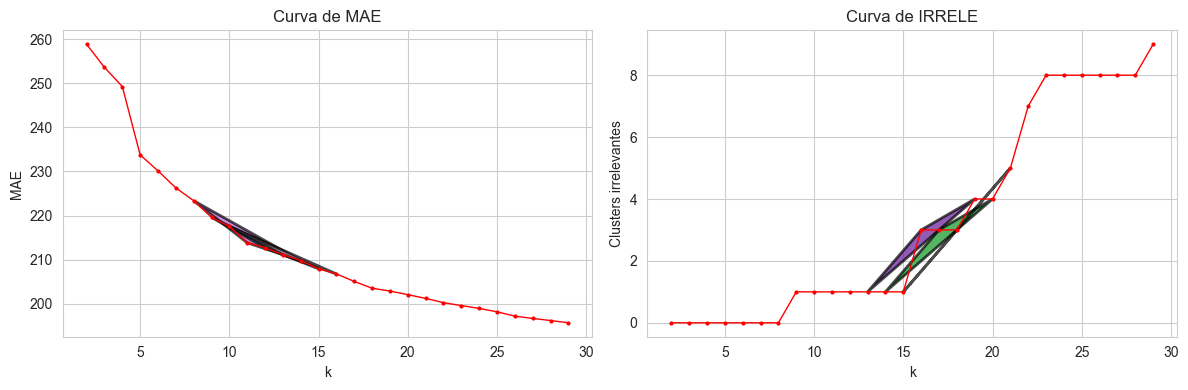

In [79]:
best_k = k_ISAC_TLP(k_values, mae_values, irreleCluster_values)

## Aplicación de K-Means con el Número Óptimo de Clusters

In [80]:
X = df.values

bkm_final = BisectingKMeans(n_clusters=best_k, random_state=42)
clusters = bkm_final.fit_predict(X)

df_clusters = df.copy()
df_clusters['cluster'] = clusters

## Guardar el Modelo Final

In [81]:
with open("pkls/bkm_24h_model_watts.pkl", "wb") as f:
    pickle.dump(bkm_final, f)

## Visualización de Resultados de Clustering

In [82]:
cluster_colors = cm.get_cmap('tab10', best_k)

### 1. Gráfico de Centroides de Clusters

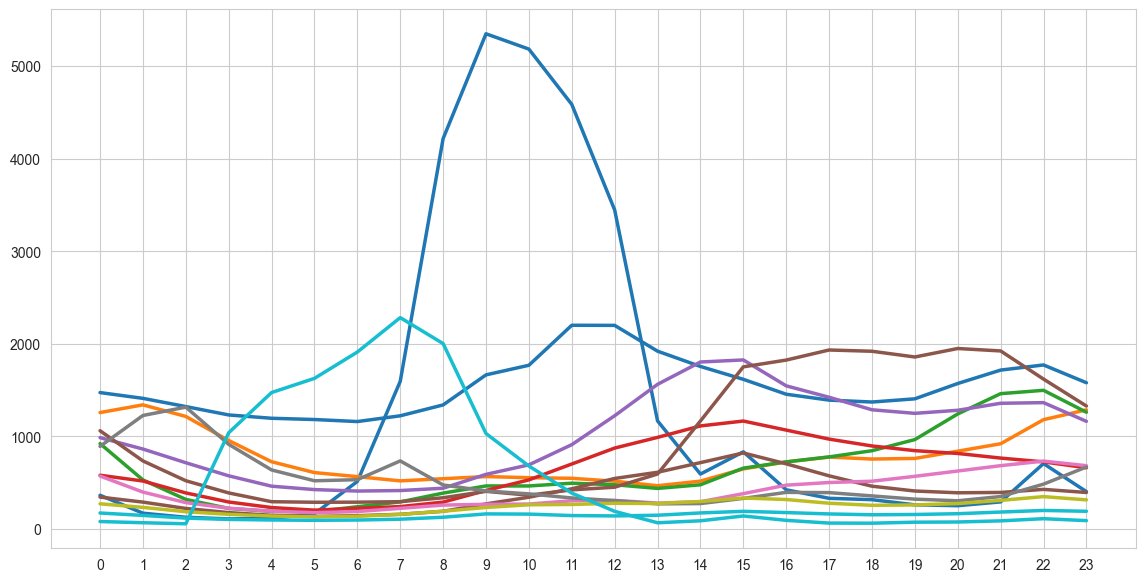

In [83]:
plt.figure(figsize=(14, 7))
for cluster_id in range(best_k):
    n_samples = (df_clusters['cluster'] == cluster_id).sum()
    plt.plot(bkm_final.cluster_centers_[cluster_id], linewidth=2.5,
             color=cluster_colors(cluster_id),
             label=f'Cluster {cluster_id} (n={n_samples})')
plt.xticks(range(0, 24))
plt.grid(True)


### 2. Distribución de Series por Cluster

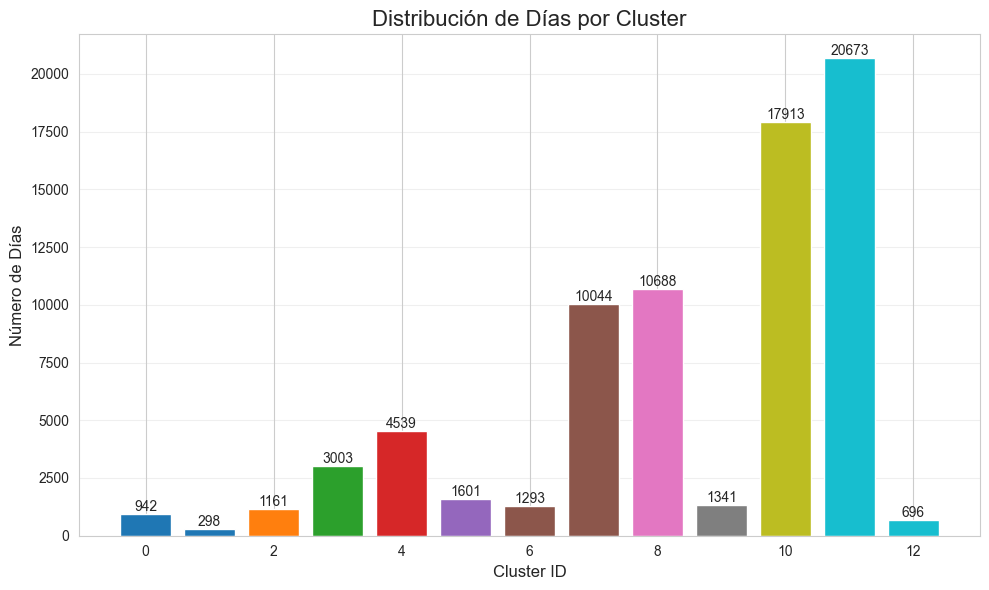

In [84]:
plt.figure(figsize=(10, 6))
cluster_counts = df_clusters['cluster'].value_counts().sort_index()

bars = plt.bar(cluster_counts.index, cluster_counts.values,
               color=[cluster_colors(i) for i in cluster_counts.index])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
             ha='center', va='bottom')

plt.title("Distribución de Días por Cluster", fontsize=16)
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("Número de Días", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [85]:
cluster_stats = pd.DataFrame({
    'Días': df_clusters['cluster'].value_counts().sort_index(),
    'Porcentaje (%)': (df_clusters['cluster'].value_counts(normalize=True).sort_index() * 100).round(2)
})

print(cluster_stats)

          Días  Porcentaje (%)
cluster                       
0          942            1.27
1          298            0.40
2         1161            1.56
3         3003            4.05
4         4539            6.12
5         1601            2.16
6         1293            1.74
7        10044           13.54
8        10688           14.41
9         1341            1.81
10       17913           24.14
11       20673           27.86
12         696            0.94


### 3. Superposición de Series con Centroides

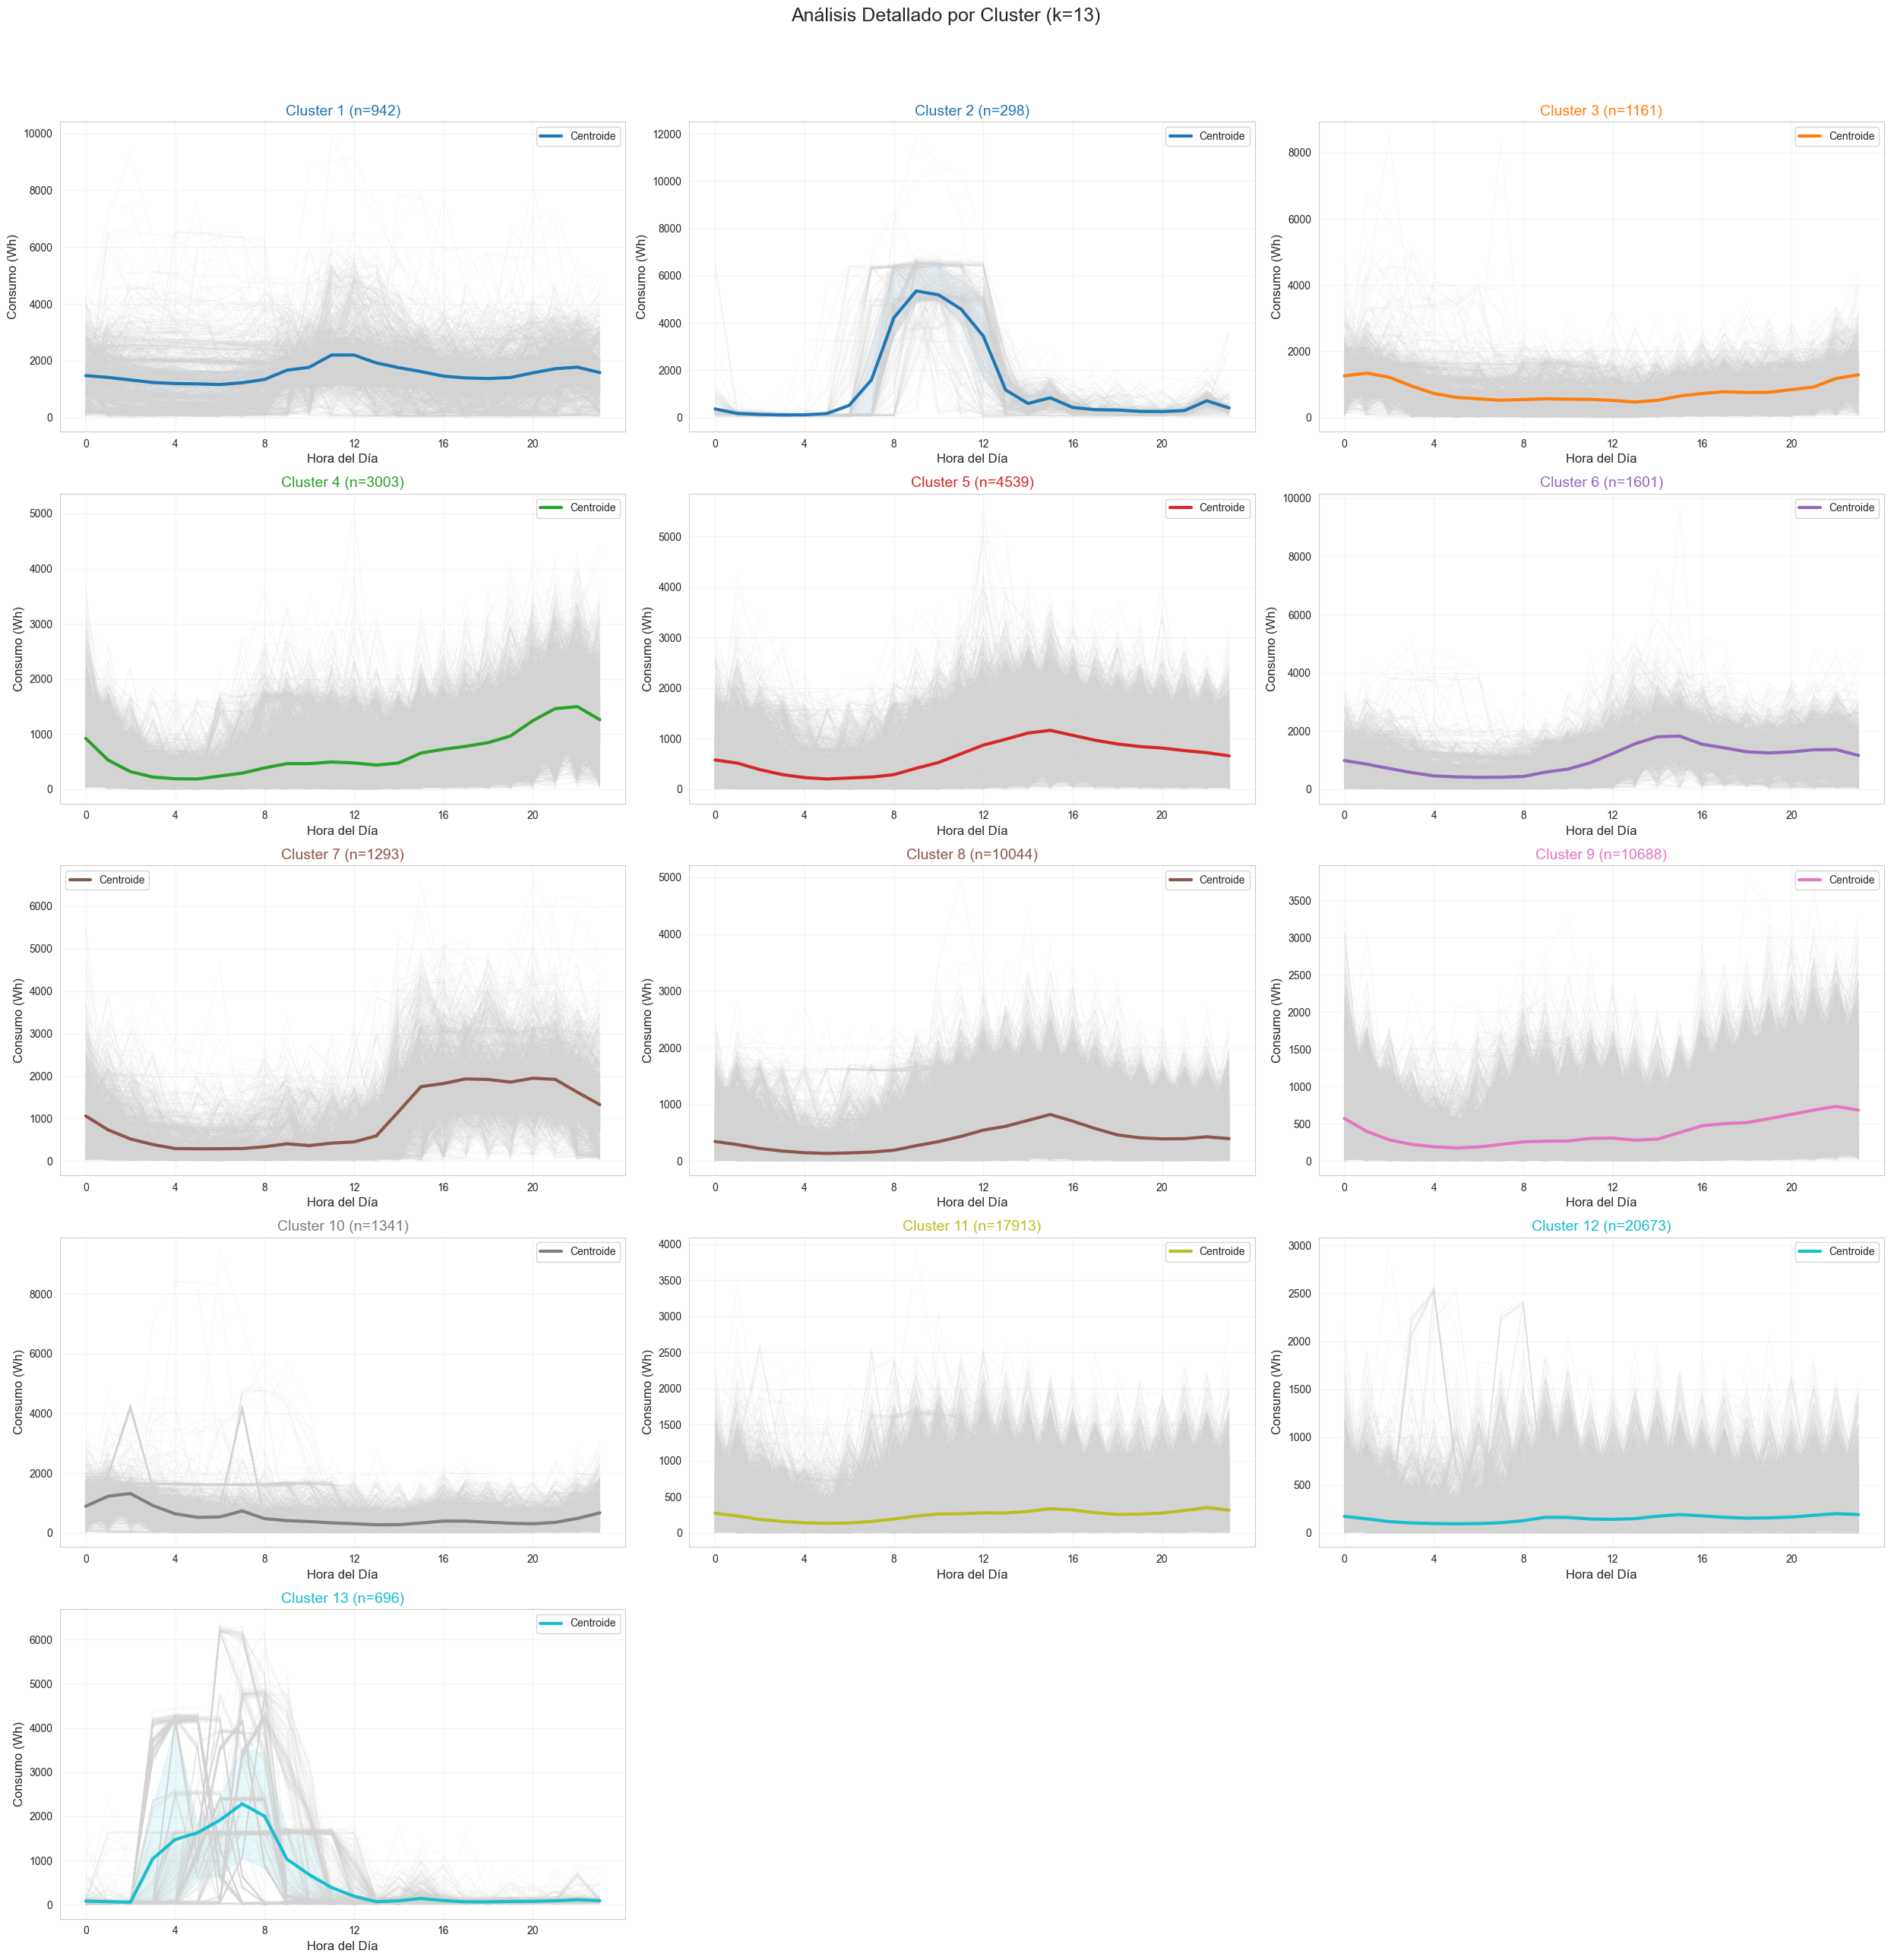

In [86]:
M = 5
N = 3 
x = np.arange(24)

fig, axs = plt.subplots(M, N, figsize=(25, 25))
fig.suptitle(f'Análisis Detallado por Cluster (k={best_k})', fontsize=18, y=1.03)
fig.tight_layout(pad=5.0)

nCent = 0
for i in range(M):
    for j in range(N):
        if nCent < best_k:
            ax = axs[i, j]
            cluster_id = nCent
            
            cluster_data = X[df_clusters['cluster'] == cluster_id]
            
            for serie in cluster_data:
                ax.plot(x, serie, color='lightgray', alpha=0.15, linewidth=0.8)
            
            ax.plot(x, bkm_final.cluster_centers_[cluster_id],
                    color=cluster_colors(cluster_id),
                    linewidth=3,
                    label='Centroide')
            
            ax.fill_between(x,
                            np.percentile(cluster_data, 25, axis=0),
                            np.percentile(cluster_data, 75, axis=0),
                            color=cluster_colors(cluster_id), alpha=0.1)
            
            ax.set_title(f'Cluster {cluster_id+1} (n={len(cluster_data)})', 
                        fontsize=14, color=cluster_colors(cluster_id))
            ax.set_xlabel("Hora del Día", fontsize=12)
            ax.set_ylabel("Consumo (Wh)", fontsize=12)
            ax.set_xticks(np.arange(0, 24, 4))
            ax.grid(True, alpha=0.2)
            ax.legend(fontsize=10)
            
            nCent += 1

for ax in axs.flat[nCent:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### 4. Visualizacion de centroides en su escala

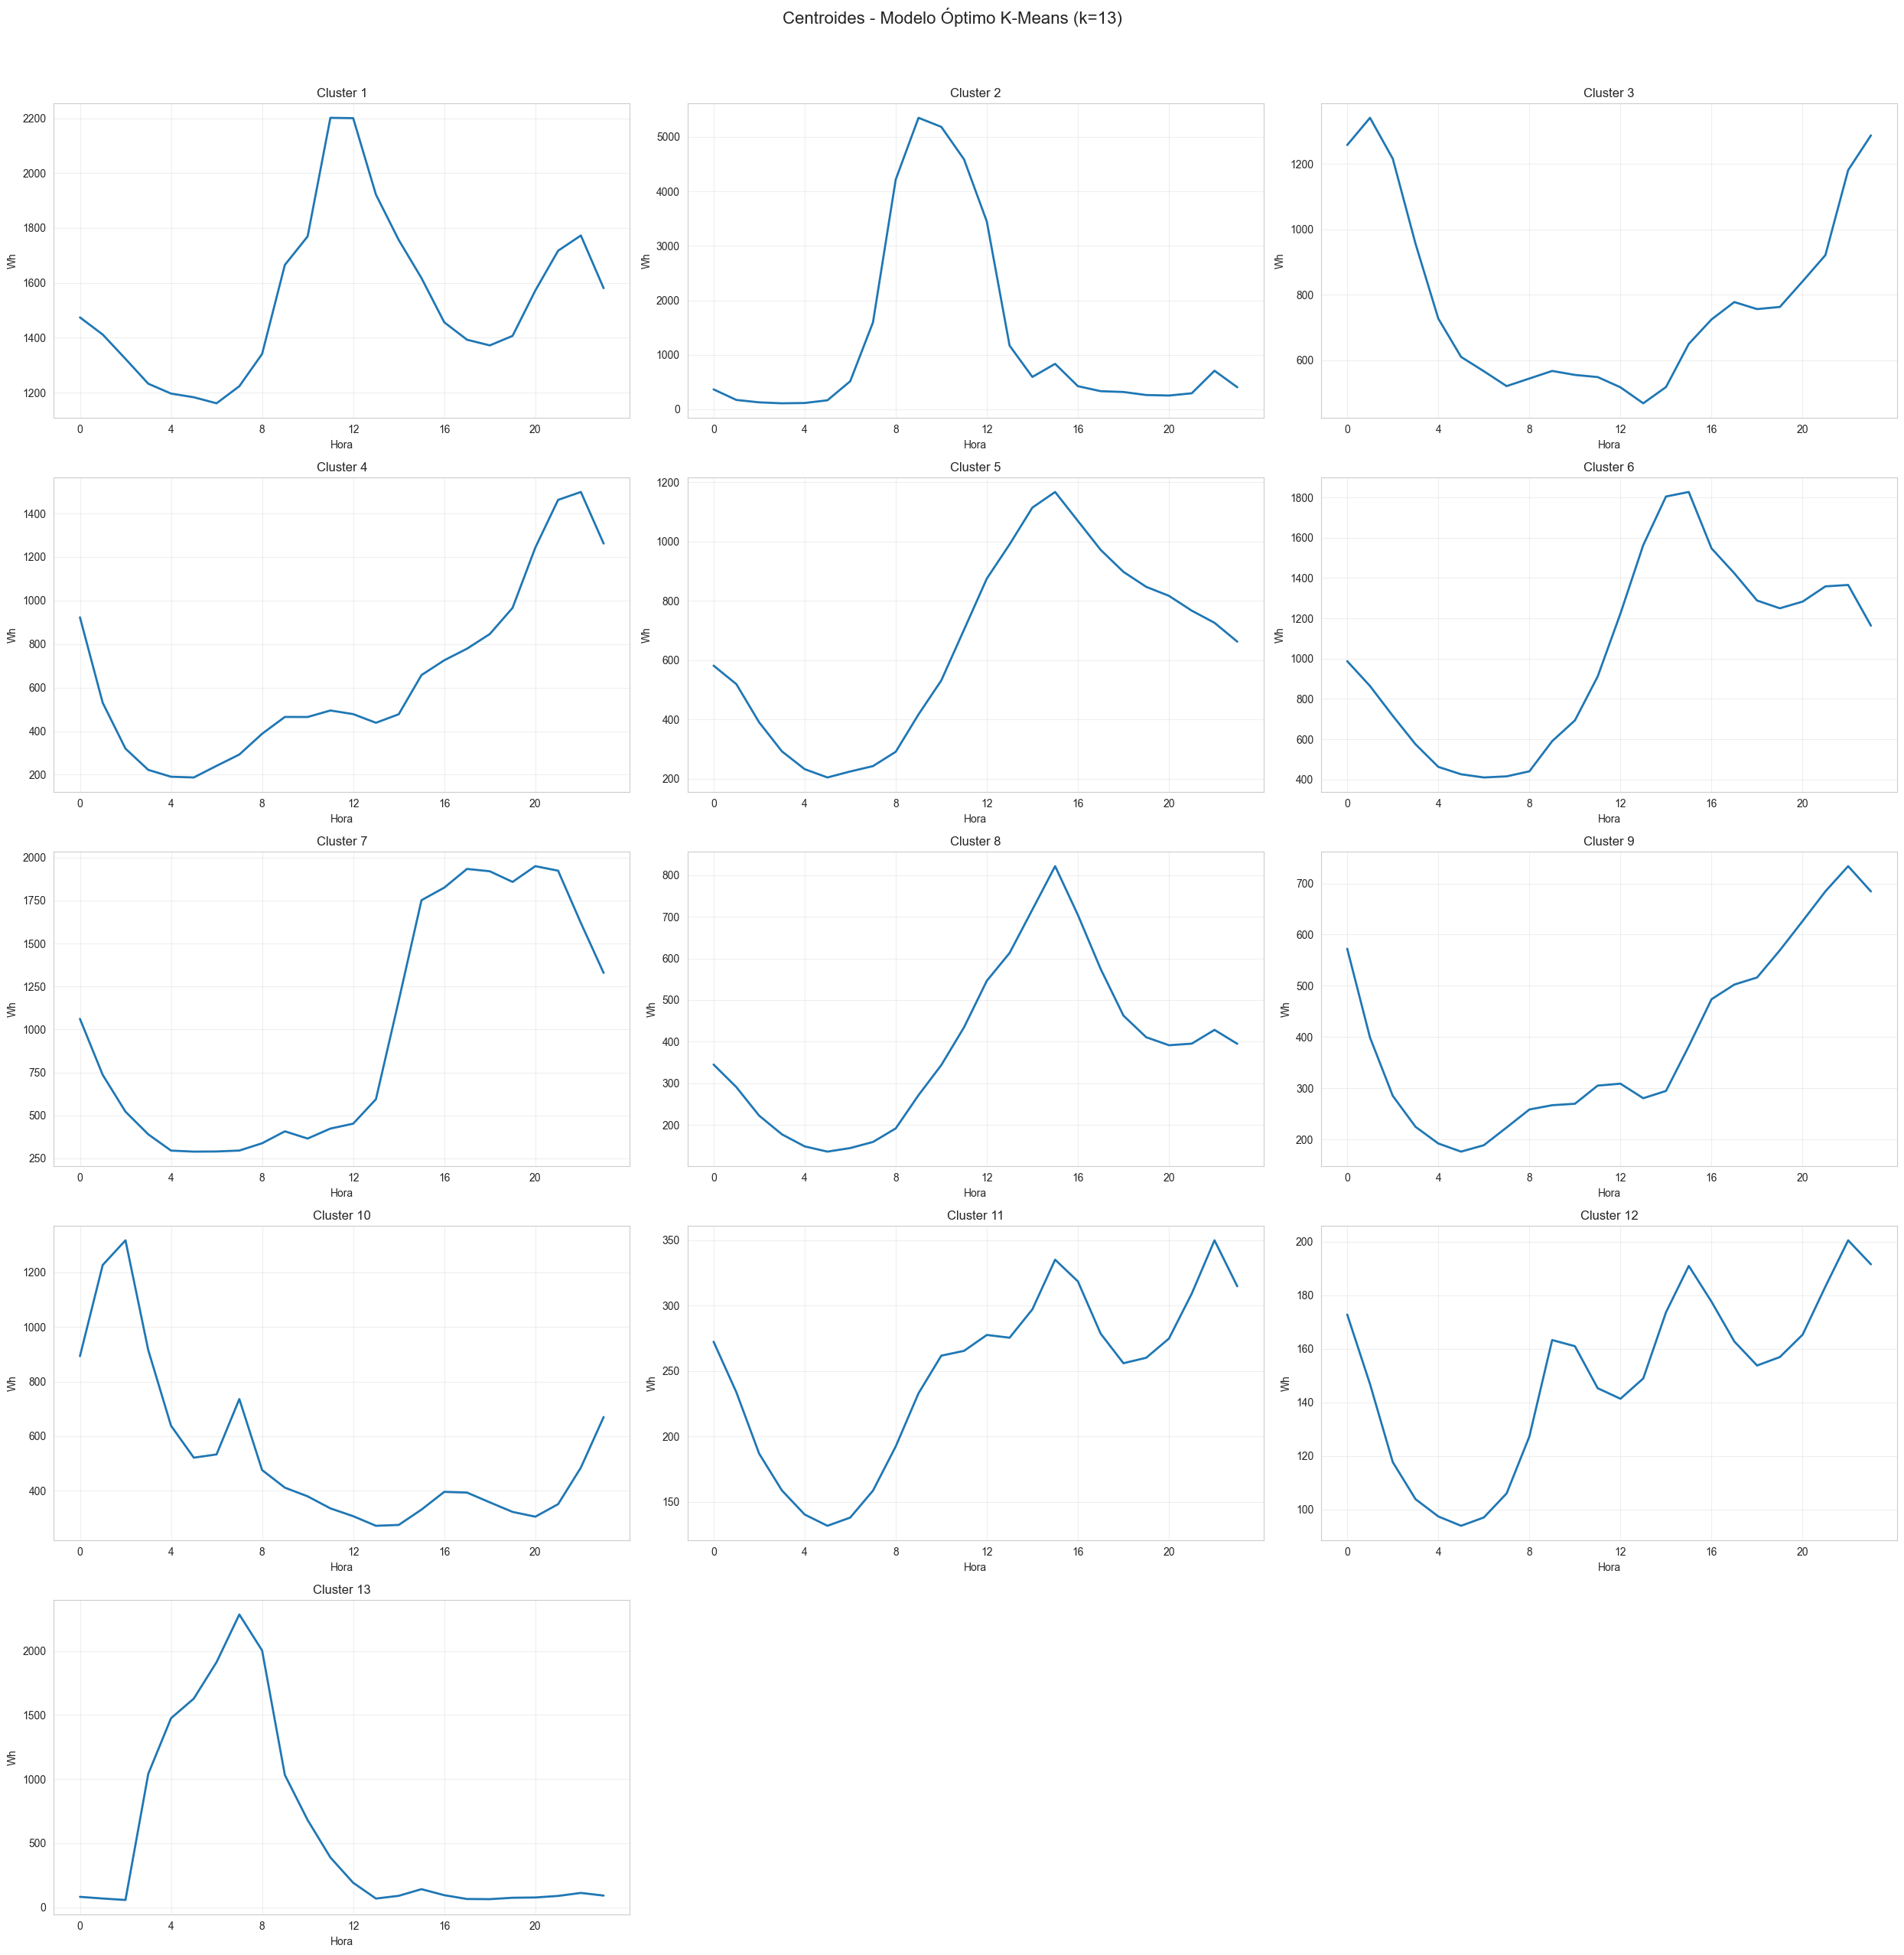

In [87]:
fig, axs = plt.subplots(M, N, figsize=(25, 25))
fig.tight_layout(pad=6.0)
fig.suptitle(f'Centroides - Modelo Óptimo K-Means (k={best_k})', fontsize=16, y=1.02)

nCent = 0
for i in range(M):
    for j in range(N):
        if nCent < best_k:
            y = bkm_final.cluster_centers_[nCent]
            axs[i, j].plot(x, y, color='tab:blue', linewidth=2)
            axs[i, j].set_title(f"Cluster {nCent+1}", fontsize=12)
            axs[i, j].set_xlabel("Hora", fontsize=10)
            axs[i, j].set_ylabel("Wh", fontsize=10)
            axs[i, j].set_xticks(np.arange(0, 24, 4))
            axs[i, j].grid(True, alpha=0.3)
            nCent += 1

for ax in axs.flat[nCent:]:
    ax.remove()

plt.tight_layout()
plt.show()

## 🔍 Análisis de Centroides – Modelo K-Means (k=13)

### 🏠 Consumo residencial (Comunidad de Getafe: Madrid)

#### Clusters principales (representan 79,25% de los días)**
- **Cluster 8**  
  - 13.54% de los dias  
  - Pico extremadamente alto en el promedio relativo entre las 12:00 y 16:00 (hasta 800 Wh). Sin embargo, consumo bajo general (200 - 800 Wh)
  - 🔸 Rellenar
- **Cluster 9**  
  - 14.41% de los dias 
  - Pico extremadamente alto en el promedio relativo entre las 20:00 y 02:00 (hasta 800 Wh), Sin embargo, consumo bajo general (200 - 800 Wh)
  - 🔸 Rellenar
- **Cluster 11**  
  - 24.14% de los dias  
  - Pico prolongado hacia el mediodía (~13–15h, hasta 300 Wh) y luego pico por la noche (20-22h, hasta 350 Wh)
  - 🔹 Perfil con poca presencia, probablemente casa vacia mientras trabajan y consumen poco cuando llegan de trabajar
- **Cluster 12**  
  - 27.86% de los dias  
  - Tres picos claros. En la mañana (09h, 160 Wh), el mediodía (~13–15h, hasta 200 Wh) y luego pico por la noche (20-22h, hasta 200 Wh)
  - 🔹 Perfil con poca presencia, probablemente casa vacia mientras trabajan y consumen poco. Patrón típico de jornada laboral (salida y regreso)

#### Clusters secundarios (representan ~15% de los días)
- **Cluster 4**  
  - 4.05% de los dias  
  - Consumo bajo por la mañana con incremento progresivo hacia la noche
  - 🔹 Perfil residencial orientado a actividad vespertina
- **Cluster 5**  
  - 6.12% de los dias 
  - Consumo bajo por la mañana con incremento progresivo hacia la noche
  - 🔹 Perfil residencial orientado a actividad vespertina
- **Cluster 6**  
  - 2.16% de los dias 
  - Similar al cluster 4 pero con pico más pronunciado al mediodía-tarde  
  - 🔹 🔹 Consumo focalizado en horas centrales del día

####  Clusters atípicos (representan <10% de los días)
- **Cluster 3**  
  - 1.56% de los dias  
  - Pico muy elevado entre 0-4h (1400 Wh)  
  - 🔹 Hogares activos en la tarde-noche
- **Cluster 9**  
  - 1.81% de los dias 
  - Muy similiar al cluster 3 pero con un poco mas nocturno (20-0h y de hasta 700Wh)  
  - 🔸 Perfil de consumo centrado en la noche
- **Cluster 13**  
  - 0.94% de los dias  
  - Pico extremadamente alto en horas de la mañana (5-8h) seguido de bajo consumo  
  - 🔸 Posible carga de vehículo eléctrico o uso industrial puntual


#### Clusters 1, 2, 7 y 13 (<5% combinados):

**Presentan diversos patrones de consumo minoritarios**
- 🔸 Representan casos especiales o combinaciones específicas
- 🔸 Pueden corresponder a hogares con hábitos de consumo únicos o a eventos específicos (ej: vacaciones, visitas, etc.)
- Por ejemplo, el cluster 2 muestro un pico muy alto en la mañana (8-12h de hasta 5500 Wh) y luego un descenso brusco hacia la tarde-noche (hasta 200 Wh). Este patrón podría corresponder a un hogar con un uso intensivo de energía en la mañana, seguido de una ausencia o baja actividad durante el resto del día. Probablemente un negocio.



### 🧠 Conclusiones generales

**Diversidad de patrones:**
- La segmentación en 13 clusters permite identificar patrones muy específicos de consumo eléctrico, mostrando la heterogeneidad en los hábitos de consumo.
- **Patrones dominantes:** Más del 75% de los días se concentran en 4 clusters principales que reflejan patrones residenciales típicos con variaciones en cuándo ocurre el consumo pico (mañana, tarde o noche).
- **Casos atípicos:** Se identifican claramente patrones de consumo inusual con picos muy pronunciados que probablemente corresponden a usos específicos (carga de vehículos eléctricos, pequeños negocios, o sistemas de alta demanda puntual).
- **Comportamiento horario:** La mayoría de los clusters muestran variaciones significativas a lo largo del día, sugiriendo que el factor horario es clave en los patrones de consumo energético residencial.
- **Potencial para gestión energética:** Esta segmentación ofrece oportunidades para diseñar estrategias de gestión de demanda y tarifas adaptadas a los diferentes perfiles identificados.

## Analisis del dataframe final: df_clusters ##

### Limpieza y preparación de df_clusters ###

In [88]:
df_clusters = df_clusters.reset_index()
df_clusters = df_clusters.drop(columns=['level_0', 'index'], errors='ignore')

df_clusters["fecha"] = pd.to_datetime(df_clusters["fecha"])
df_clusters["dia_semana"] = df_clusters["fecha"].dt.day_name()
df_clusters["mes"] = df_clusters["fecha"].dt.month

def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return "Invierno"
    elif mes in [3, 4, 5]:
        return "Primavera"
    elif mes in [6, 7, 8]:
        return "Verano"
    else:
        return "Otoño"

df_clusters["estacion"] = df_clusters["mes"].apply(obtener_estacion)

### 1. Distribución de clusters por CUPS (formato porcentaje)

In [89]:
cups_cluster_dist = (
    df_clusters.groupby('cups')['cluster']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .unstack(fill_value=0)
    .reset_index()
)

cups_cluster_dist.to_csv("output/cups_por_cluster.csv", index=False)

for cups in cups_cluster_dist['cups']:
    print(f"\nCUPS: {cups}")
    for cluster, porcentaje in cups_cluster_dist.set_index('cups').loc[cups].items():
        if porcentaje > 0:
            print(f"  Cluster {cluster}: {porcentaje}%")


CUPS: 0114f2a9ef8e
  Cluster 3: 0.14%
  Cluster 4: 0.69%
  Cluster 6: 0.27%
  Cluster 7: 49.45%
  Cluster 8: 41.48%
  Cluster 10: 7.83%
  Cluster 11: 0.14%

CUPS: 011952cf0a27
  Cluster 2: 1.1%
  Cluster 3: 1.23%
  Cluster 4: 11.23%
  Cluster 5: 0.14%
  Cluster 6: 0.14%
  Cluster 7: 46.16%
  Cluster 8: 33.29%
  Cluster 9: 1.78%
  Cluster 10: 4.52%
  Cluster 11: 0.41%

CUPS: 02b3106d73c7
  Cluster 2: 6.79%
  Cluster 3: 16.04%
  Cluster 4: 9.54%
  Cluster 5: 1.88%
  Cluster 6: 2.75%
  Cluster 7: 18.64%
  Cluster 8: 11.85%
  Cluster 9: 1.59%
  Cluster 10: 18.06%
  Cluster 11: 12.86%

CUPS: 03c8338d7f1d
  Cluster 7: 0.41%
  Cluster 8: 0.27%
  Cluster 10: 29.4%
  Cluster 11: 69.92%

CUPS: 04666163609d
  Cluster 3: 3.19%
  Cluster 4: 3.33%
  Cluster 6: 0.58%
  Cluster 7: 8.84%
  Cluster 8: 16.81%
  Cluster 10: 34.06%
  Cluster 11: 33.19%

CUPS: 07efa654691a
  Cluster 2: 4.85%
  Cluster 3: 5.29%
  Cluster 4: 14.71%
  Cluster 5: 1.18%
  Cluster 6: 0.74%
  Cluster 7: 25.74%
  Cluster 8: 22.5%


### 2. Distribución de CUPS por cluster

In [90]:
cluster_cups_dist = (
    df_clusters.groupby('cluster')['cups']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .unstack(fill_value=0)
    .reset_index()
)

cluster_cups_dist.to_csv("output/cluster_por_cups.csv", index=False)

for cluster in sorted(df_clusters['cluster'].unique()):
    print(f"\nCluster {cluster}:")
    top_cups = cluster_cups_dist.set_index('cluster').loc[cluster].nlargest(3)
    for cups, porcentaje in top_cups.items():
        if porcentaje > 0:
            print(f"  CUPS {cups}: {porcentaje}%")


Cluster 0:
  CUPS ab80ec0882ca: 32.17%
  CUPS b1a8b5dfd391: 17.83%
  CUPS 84bc6f535519: 11.78%

Cluster 1:
  CUPS d55816977df1: 94.63%
  CUPS 127a14c3f85b: 3.02%
  CUPS c4a177fb3092: 1.01%

Cluster 2:
  CUPS c4a177fb3092: 9.39%
  CUPS 60e6d6d2541a: 6.63%
  CUPS 6f00c403abd0: 6.2%

Cluster 3:
  CUPS 259e3b12740a: 5.46%
  CUPS 5050e482704a: 5.29%
  CUPS 883788a8f885: 4.63%

Cluster 4:
  CUPS 7a2e7beb0672: 5.88%
  CUPS 5050e482704a: 5.11%
  CUPS 6f00c403abd0: 4.87%

Cluster 5:
  CUPS 5050e482704a: 7.93%
  CUPS b1a8b5dfd391: 7.87%
  CUPS a1c7814da365: 6.93%

Cluster 6:
  CUPS c762bb72bd52: 13.07%
  CUPS bf03a8cf21da: 8.35%
  CUPS f031c514ae35: 6.03%

Cluster 7:
  CUPS 0114f2a9ef8e: 3.58%
  CUPS 011952cf0a27: 3.36%
  CUPS 0d9678df292f: 3.14%

Cluster 8:
  CUPS f01cc7652e9e: 3.61%
  CUPS b46938568ddc: 3.26%
  CUPS 7a6739bd338e: 3.07%

Cluster 9:
  CUPS a436c4d5cbeb: 8.8%
  CUPS e00164f28d81: 7.98%
  CUPS 07efa654691a: 7.9%

Cluster 10:
  CUPS 2b6fe1934f34: 2.99%
  CUPS 736f2de66813: 2.58%
 

### 3. Distribución de días de la semana por cluster

In [91]:
dias_semana_dist = (
    df_clusters.groupby('cluster')['dia_semana']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .unstack(fill_value=0)
    .reset_index()
)

dias_semana_dist.to_csv("output/dias_por_cluster.csv", index=False)

for cluster in sorted(df_clusters['cluster'].unique()):
    print(f"\nCluster {cluster}:")
    dias_dist = dias_semana_dist.set_index('cluster').loc[cluster].sort_values(ascending=False)
    for dia, porcentaje in dias_dist.items():
        if porcentaje > 0:
            print(f"  {dia}: {porcentaje}%")



Cluster 0:
  Saturday: 17.09%
  Wednesday: 14.65%
  Friday: 14.33%
  Sunday: 14.23%
  Thursday: 13.59%
  Monday: 13.16%
  Tuesday: 12.95%

Cluster 1:
  Friday: 15.44%
  Thursday: 14.77%
  Monday: 14.43%
  Wednesday: 14.43%
  Saturday: 14.09%
  Sunday: 13.76%
  Tuesday: 13.09%

Cluster 2:
  Tuesday: 16.54%
  Friday: 15.85%
  Monday: 15.59%
  Wednesday: 14.81%
  Thursday: 13.95%
  Saturday: 12.06%
  Sunday: 11.2%

Cluster 3:
  Thursday: 16.62%
  Tuesday: 16.35%
  Wednesday: 16.02%
  Monday: 15.72%
  Friday: 13.79%
  Sunday: 11.85%
  Saturday: 9.66%

Cluster 4:
  Saturday: 18.66%
  Sunday: 17.85%
  Friday: 13.31%
  Wednesday: 13.26%
  Thursday: 12.4%
  Tuesday: 12.32%
  Monday: 12.21%

Cluster 5:
  Sunday: 22.3%
  Saturday: 18.74%
  Tuesday: 12.93%
  Thursday: 12.43%
  Wednesday: 11.68%
  Friday: 11.62%
  Monday: 10.31%

Cluster 6:
  Monday: 16.47%
  Thursday: 14.69%
  Wednesday: 14.62%
  Friday: 14.39%
  Sunday: 13.77%
  Tuesday: 13.53%
  Saturday: 12.53%

Cluster 7:
  Sunday: 17.31%
  

### 4. Distribución de estaciones por cluster


In [92]:
estaciones_dist = (
    df_clusters.groupby('cluster')['estacion']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .unstack(fill_value=0)
    .reset_index()
)
estaciones_dist.to_csv("output/estaciones_por_cluster.csv", index=False)

for cluster in sorted(df_clusters['cluster'].unique()):
    print(f"\nCluster {cluster}:")
    estaciones = estaciones_dist.set_index('cluster').loc[cluster].sort_values(ascending=False)
    for estacion, porcentaje in estaciones.items():
        if porcentaje > 0:
            print(f"  {estacion}: {porcentaje}%")


Cluster 0:
  Invierno: 61.78%
  Primavera: 16.03%
  Verano: 12.31%
  Otoño: 9.87%

Cluster 1:
  Invierno: 61.07%
  Primavera: 26.85%
  Otoño: 12.08%

Cluster 2:
  Verano: 37.04%
  Invierno: 30.06%
  Primavera: 18.52%
  Otoño: 14.38%

Cluster 3:
  Invierno: 38.63%
  Primavera: 25.77%
  Otoño: 17.88%
  Verano: 17.72%

Cluster 4:
  Invierno: 32.91%
  Verano: 24.79%
  Primavera: 23.97%
  Otoño: 18.33%

Cluster 5:
  Invierno: 46.6%
  Verano: 24.67%
  Primavera: 16.74%
  Otoño: 11.99%

Cluster 6:
  Invierno: 56.23%
  Verano: 17.09%
  Primavera: 17.01%
  Otoño: 9.67%

Cluster 7:
  Primavera: 26.21%
  Invierno: 25.45%
  Otoño: 24.18%
  Verano: 24.15%

Cluster 8:
  Verano: 27.41%
  Invierno: 26.03%
  Primavera: 24.7%
  Otoño: 21.86%

Cluster 9:
  Invierno: 33.33%
  Verano: 31.02%
  Otoño: 18.34%
  Primavera: 17.3%

Cluster 10:
  Primavera: 27.53%
  Otoño: 27.25%
  Verano: 24.31%
  Invierno: 20.91%

Cluster 11:
  Primavera: 27.83%
  Otoño: 27.18%
  Verano: 27.04%
  Invierno: 17.95%

Cluster 12:

### Comparación con otros estudios
**Diferencias clave**:
   - Utiliza una muestra del dataset completo de España (Getafe). Puede no ser representativa de otras regiones.
   - Se centra en el análisis de patrones de consumo diario (24h)
### Ventajas de la metodología propuesta
**Procesamiento simplificado**:
- **Sin normalización**:  
  ✔ Mantiene rangos absolutos  
  ✔ Permite comparación directa entre perfiles  
- **Sin segmentación artificial**:  
  ✔ Conserva patrones naturales por estación/día  
- **Adaptable a diferentes regiones**:  
  ✔ Permite análisis de patrones específicos por región  
  ✔ Facilita la identificación de perfiles únicos en cada área
### Limitaciones y futuros trabajos
**Desafíos actuales**:
- Ineficiencia con rangos de 𝑘 muy amplios
- Dificultad para ajustar parámetros ISAC por dominio
